In [ ]:
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 14})

from cosmoprimo import *

from densitysplit import catalog_data, density_split
from densitysplit.split_model import *
from densitysplit.corr_func_utils import *

# To activate logging
setup_logging()

## Cosmology

In [ ]:
z = 1.175

# Abacus summit base cosmology
cosmo_abacus = fiducial.AbacusSummitBase()
bg = cosmo_abacus.get_background()

k=np.logspace(-5, 3, 100000)

## Gaussian mock to compare to model

In [ ]:
output_dir = '/feynman/work/dphp/mp270220/outputs/'

mock_catalog = catalog_data.Data.load(output_dir+'mocks/gaussian/AbacusSummit_2Gpc_z1.175_gaussianMock0_truncatedPk_nbarx5.npy')
nbar = mock_catalog.size/mock_catalog.boxsize**3

In [ ]:
cellsize = 10
resampler = 'tsc'

In [ ]:
mock_catalog.size

117316470

### Compute density

In [ ]:
shot_noise = 404.5190448471664

In [ ]:
#1/nbar

## Split model

In [ ]:
kN = np.pi*1024/mock_catalog.boxsize
kN

1.6084954386379742

In [ ]:
def damping_function(k, k_lambda=0.8*kN, sigma_lambda=0.05*kN):
    if k < k_lambda:
        return 1
    else:
        return np.exp(-(k-k_lambda)**2/(2*sigma_lambda**2))

In [ ]:
pklin = cosmo_abacus.get_fourier().pk_interpolator(extrap_kmin=1e-6, extrap_kmax=1e3).to_1d(z)
pklin_array = pklin(k)
pkdamped_func = lambda k: pklin(k) * np.array([damping_function(kk) for kk in k])
pkdamped = PowerSpectrumInterpolator1D.from_callable(k, pkdamped_func)

In [ ]:
model1 = SplitCCFModel(k, redshift=z, cosmology=cosmo_abacus, bias=1.8, nsplits=1)
model = SplitCCFModel(k, redshift=z, cosmology=cosmo_abacus, bias=1.8, nsplits=1, shot_noise=shot_noise)

model1.set_pk_model(pk=pkdamped)
model.set_pk_model(pk=pkdamped)

In [ ]:
model.sigma_RR

array([0.52716684])

In [ ]:
# Get theoretical quantiles
import scipy.stats

th_bins = scipy.stats.norm.ppf(q=[0, 1./3, 2./3, 1], loc=0, scale=model.sigma_RR)

In [ ]:
th_bins

array([       -inf, -0.22706515,  0.22706515,         inf])

In [ ]:
model.sigma_R

array([0.7000267])

## Compute density split CCFs (randoms-tracers)

In [ ]:
ccf_randoms_tracers = model.ccf_randoms_tracers(density_bins=th_bins)
ccf_randoms_tracers1 = model1.ccf_randoms_tracers(density_bins=th_bins)

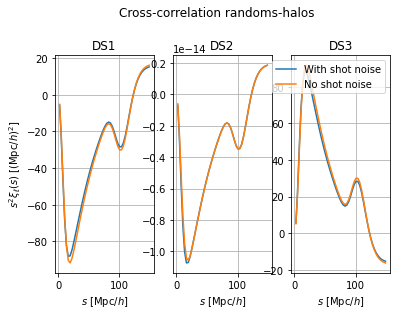

In [ ]:
plt.rcParams["figure.figsize"] = (20, 5)
fig, axes = plt.subplots(1, 3, sharex=False, sharey=False)

s = model.sep

for i in range(model.nsplits):
    axes[i].plot(s, s**2 * ccf_randoms_tracers[i], label='With shot noise')
    axes[i].plot(s, s**2 * ccf_randoms_tracers1[i], label='No shot noise')
    axes[i].grid(True)
    axes[i].set_title('DS{}'.format(i+1))    
    axes[i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

axes[0].set_ylabel(r'$s^2 \xi_{\ell}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[2].legend()

plt.suptitle('Cross-correlation randoms-halos', y=1.05)
plt.show()

In [ ]:
mocks_split_results_1Gpc = np.load(output_dir+'correlation_functions/AbacusSummit_1Gpc_z1.175'+'_10_gaussianMocks_truncatedPk_nbarx5_densitySplit_rh_CCF_cellsize10_randomsize4.npy', allow_pickle=True)
mocks_xiell_rh_1Gpc, cov_rh_1Gpc = get_split_poles(mocks_split_results_1Gpc, ells=[0], nsplits=model.nsplits)
std_rh_1Gpc = np.array_split(np.array(np.array_split(np.diag(cov_rh_1Gpc)**0.5, 1)), model.nsplits, axis=1)/np.sqrt(10)

In [ ]:
mocks_split_results_2Gpc = np.load(output_dir+'AbacusSummit_2Gpc_z1.175'+'_10_gaussianMocks_truncatedPk_nbarx5_densitySplit_rh_CCF_cellsize10_randomsize4_all.npy', allow_pickle=True)
mocks_xiell_rh_2Gpc, cov_rh_2Gpc = get_split_poles(mocks_split_results_2Gpc, ells=[0], nsplits=model.nsplits)
std_rh_2Gpc = np.array_split(np.array(np.array_split(np.diag(cov_rh_2Gpc)**0.5, 1)), model.nsplits, axis=1)/np.sqrt(10)

In [ ]:
mocks_split_results_2Gpc_fixedBins = np.load(output_dir+'AbacusSummit_2Gpc_z1.175'+'_10_gaussianMocks_truncatedPk_nbarx5_densitySplit_fixedBins_rh_CCF_cellsize10_randomsize4_all.npy', allow_pickle=True)
mocks_xiell_rh_2Gpc_fixedBins, cov_rh_2Gpc_fixedBins = get_split_poles(mocks_split_results_2Gpc_fixedBins, ells=[0], nsplits=model.nsplits)
std_rh_2Gpc_fixedBins = np.array_split(np.array(np.array_split(np.diag(cov_rh_2Gpc_fixedBins)**0.5, 1)), model.nsplits, axis=1)/np.sqrt(10)

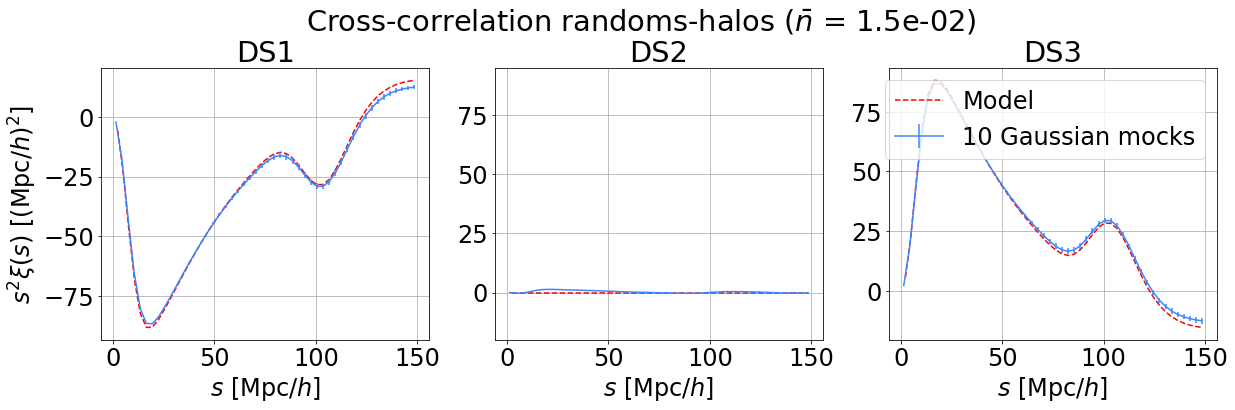

In [ ]:
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams.update({'font.size': 14})

fig, axes = plt.subplots(1, 3, sharex=False, sharey=False)

s, _, res = mocks_split_results_1Gpc[0][0].get_corr(return_sep=True)
sep = model.sep

for i in range(model.nsplits):
    axes[i].plot(sep, sep**2 * ccf_randoms_tracers[i], label = 'Model (with shot noise)', ls='--', color='C1')
    #axes[i].plot(sep, sep**2 * ccf_randoms_tracers1[i], label = 'Split model (no shot noise)', ls='--', color='C1')
    axes[i].errorbar(s, s**2 * mocks_xiell_rh_1Gpc[i][0], s**2 * std_rh_1Gpc[i][0], label = r'10 Gaussian mocks (1Gpc)', color='skyblue')# ($\bar{{n}}$ = {:.1e})'.format(nbar), color='C0')
    axes[i].errorbar(s, s**2 * mocks_xiell_rh_2Gpc[i][0], s**2 * std_rh_2Gpc[i][0], label = r'10 Gaussian mocks (2Gpc)', color='C0')# ($\bar{{n}}$ = {:.1e})'.format(nbar), color='C0')
    axes[i].errorbar(s, s**2 * mocks_xiell_rh_2Gpc_fixedBins[i][0], s**2 * std_rh_2Gpc_fixedBins[i][0], label = r'10 Gaussian mocks (2Gpc, fixed bins)', color='purple')# ($\bar{{n}}$ = {:.1e})'.format(nbar), color='C0')
    axes[i].grid(True)
    axes[i].set_title('DS{}'.format(i+1))    
    axes[i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

axes[0].set_ylabel(r'$s^2 \xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
#axes[1].set_ylim((-20, 20))
axes[2].legend()

plt.suptitle(r'Cross-correlation randoms-halos ($\bar{{n}}$ = {:.1e})'.format(nbar), y=1.05)
plt.show()

## Compute density split CCFs (tracers-tracers)

In [22]:
from densitysplit import catalog_data, density_split
from densitysplit.split_model import *

In [23]:
ccf_tracers = model.ccf_tracers(density_bins=th_bins)
ccf_tracers1 = model1.ccf_tracers(density_bins=th_bins)

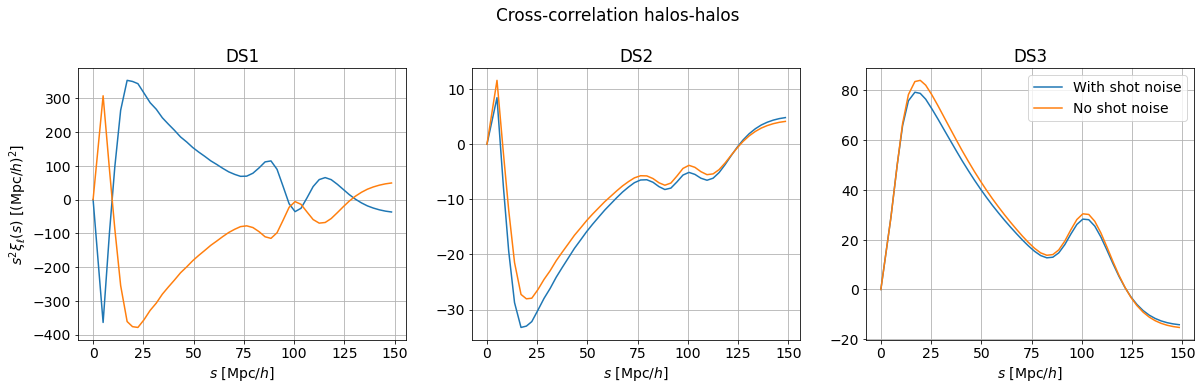

In [24]:
plt.rcParams["figure.figsize"] = (20, 5)
fig, axes = plt.subplots(1, 3, sharex=False, sharey=False)

sep = model.sep

for i in range(model.nsplits):
    axes[i].plot(sep, sep**2 * ccf_tracers[i], label='With shot noise')
    axes[i].plot(sep, sep**2 * ccf_tracers1[i], label='No shot noise')
    axes[i].grid(True)
    axes[i].set_title('DS{}'.format(i+1))    
    axes[i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

axes[0].set_ylabel(r'$s^2 \xi_{\ell}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[2].legend()

plt.suptitle('Cross-correlation halos-halos', y=1.05)
plt.show()

In [25]:
mocks_split_results_1Gpc = np.load(output_dir+'correlation_functions/AbacusSummit_1Gpc_z1.175'+'_10_gaussianMocks_truncatedPk_nbarx5_densitySplit_hh_CCF_cellsize10_randomsize4.npy', allow_pickle=True)
mocks_xiell_hh_1Gpc, cov_hh_1Gpc = get_split_poles(mocks_split_results_1Gpc, ells=[0], nsplits=model.nsplits)
std_hh_1Gpc = np.array_split(np.array(np.array_split(np.diag(cov_hh_1Gpc)**0.5, 1)), model.nsplits, axis=1)/np.sqrt(10)

In [26]:
mocks_split_results_2Gpc = np.load(output_dir+'AbacusSummit_2Gpc_z1.175'+'_10_gaussianMocks_truncatedPk_nbarx5_densitySplit_hh_CCF_cellsize10_randomsize4_all.npy', allow_pickle=True)
mocks_xiell_hh_2Gpc, cov_hh_2Gpc = get_split_poles(mocks_split_results_2Gpc, ells=[0], nsplits=model.nsplits)
std_hh_2Gpc = np.array_split(np.array(np.array_split(np.diag(cov_hh_2Gpc)**0.5, 1)), model.nsplits, axis=1)/np.sqrt(10)

In [27]:
mocks_split_results_2Gpc_fixedBins = np.load(output_dir+'AbacusSummit_2Gpc_z1.175'+'_10_gaussianMocks_truncatedPk_nbarx5_densitySplit_fixedBins_hh_CCF_cellsize10_randomsize4_all.npy', allow_pickle=True)
mocks_xiell_hh_2Gpc_fixedBins, cov_hh_2Gpc_fixedBins = get_split_poles(mocks_split_results_2Gpc_fixedBins, ells=[0], nsplits=model.nsplits)
std_hh_2Gpc_fixedBins = np.array_split(np.array(np.array_split(np.diag(cov_hh_2Gpc_fixedBins)**0.5, 1)), model.nsplits, axis=1)/np.sqrt(10)

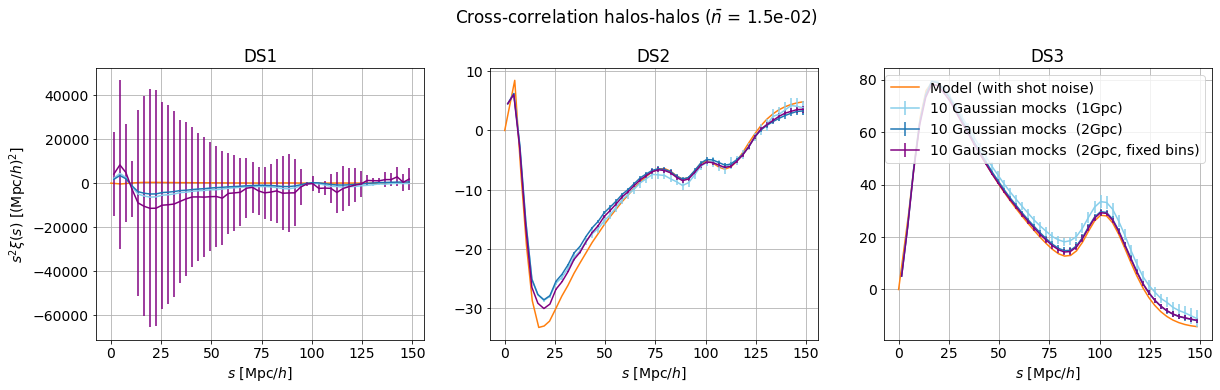

In [28]:
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams.update({'font.size': 14})

fig, axes = plt.subplots(1, 3, sharex=False, sharey=False)

s, _, res = mocks_split_results_1Gpc[0][0].get_corr(return_sep=True)
sep = model.sep

for i in range(model.nsplits):
    axes[i].plot(sep, sep**2 * ccf_tracers[i], label = 'Model (with shot noise)', ls='-', color='C1')
#    axes[i].plot(sep, sep**2 * ccf_tracers1[i], label = 'Split model (no shot noise)', ls='--', color='C1')
    axes[i].errorbar(s, s**2 * mocks_xiell_hh_1Gpc[i][0], s**2 * std_hh_1Gpc[i][0], label = r'10 Gaussian mocks  (1Gpc)', color='skyblue') #($\bar{{n}}$ = {:.1e})'.format(nbar), color='C0')
    axes[i].errorbar(s, s**2 * mocks_xiell_hh_2Gpc[i][0], s**2 * std_hh_2Gpc[i][0], label = r'10 Gaussian mocks  (2Gpc)', color='C0')
    axes[i].errorbar(s, s**2 * mocks_xiell_hh_2Gpc_fixedBins[i][0], s**2 * std_hh_2Gpc_fixedBins[i][0], label = r'10 Gaussian mocks  (2Gpc, fixed bins)', color='purple')
    axes[i].grid(True)
    axes[i].set_title('DS{}'.format(i+1))    
    axes[i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

axes[0].set_ylabel(r'$s^2 \xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[2].legend()

plt.suptitle(r'Cross-correlation halos-halos ($\bar{{n}}$ = {:.1e})'.format(nbar), y=1.05)
plt.show()